ref for data preprocessing & postprocessing: https://www.kaggle.com/code/gordonyip/host-starter-solution

# imports and intializations

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
# from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.loggers import CSVLogger #,TensorBoardLogger #,WandbLogger


seed = 42
pl.seed_everything(seed)

# trainer
accelerator = 'gpu'
devices = 1



[rank: 0] Seed set to 42


# load dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import pandas as pd
import seaborn as sns

import torchvision.transforms.functional as TF



In [5]:
task = 'finalunet'

data_folder = '/home/ulaval.ca/maelr5/scratch/binned-dataset-v1/' # path to the folder containing the data
auxiliary_folder = '/home/ulaval.ca/maelr5/scratch/ariel-data-challenge/' # path to the folder containing the train targets and wavelengths informations

data_train_AIRS = np.load(f'{data_folder}/data_train.npy')
data_train_FGS = np.load(f'{data_folder}/data_train_FGS.npy')

output_dir = f'/home/ulaval.ca/maelr5/scratch/{task}_outputs' #'./output'

do_the_mcdropout_wc = True
do_the_mcdropout = True

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")



Directory /home/ulaval.ca/maelr5/scratch/finalunet_outputs already exists.


In [6]:
train_df = pd.read_csv(f'{auxiliary_folder}/train_labels.csv')
print(len(train_df))
train_df.head()


673


,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
0,785834,0.001086,0.001137,0.001131,0.001124,0.001138,0.001131,0.001123,0.001127,0.001120,...,0.001075,0.001076,0.001076,0.001076,0.001074,0.001073,0.001072,0.001073,0.001073,0.001072
1,14485303,0.001835,0.001835,0.001834,0.001833,0.001833,0.001833,0.001833,0.001834,0.001834,...,0.001893,0.001892,0.001892,0.001891,0.001891,0.001891,0.001890,0.001890,0.001889,0.001888
2,17002355,0.002792,0.002814,0.002808,0.002804,0.002809,0.002805,0.002802,0.002805,0.002801,...,0.002784,0.002783,0.002783,0.002783,0.002783,0.002784,0.002784,0.002785,0.002785,0.002784
3,24135240,0.001294,0.001308,0.001308,0.001306,0.001306,0.001303,0.001306,0.001314,0.001314,...,0.001405,0.001404,0.001403,0.001402,0.001401,0.001400,0.001399,0.001397,0.001395,0.001393
4,25070640,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,...,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988



We create the dataset by adding the FGS frame, crushed in one column, at the end of the AIRS data cube.
The images are normalized using the star spectrum extracted from the images themselves.

we sum up the pixels on the y-axis to transform the data into 2D images.



In [7]:
train_solution = np.loadtxt(f'{auxiliary_folder}/train_labels.csv', delimiter = ',', skiprows = 1)

targets = train_solution[:,1:-1]
# targets_mean = targets[:,1:-1].mean(axis = 1) # used for the 1D-CNN to extract the mean value, only AIRS wavelengths 
# as the FGS point is not used in the white curve
N = targets.shape[0]
print(N, targets.shape)
# print(data_train.shape, data_train_FGS.shape)


# signal_AIRS_diff_transposed_binned, signal_FGS_diff_transposed_binned  = data_train, data_train_FGS
# FGS_column = signal_FGS_diff_transposed_binned.sum(axis = 2)
# dataset = np.concatenate([signal_AIRS_diff_transposed_binned, FGS_column[:,:, np.newaxis,:]], axis = 2)
# print('dataset shape= ', dataset.shape)

print('data_train_AIRS', data_train_AIRS.shape, 'data_train_FGS', data_train_FGS.shape)
# use just the AIRS-CH0 data
dataset = data_train_AIRS
print('dataset shape= ', dataset.shape)

dataset = dataset.sum(axis=3)
print('dataset shape= ', dataset.shape)




673 (673, 282)
data_train_AIRS (673, 187, 282, 32) data_train_FGS (673, 187, 32, 32)
dataset shape=  (673, 187, 282, 32)
dataset shape=  (673, 187, 282)


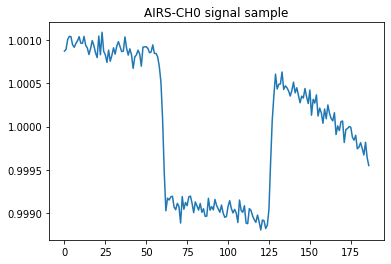

In [8]:
lc = data_train_AIRS[15].sum(axis=(1,2))
plt.plot(lc/lc.mean())
plt.title(f'AIRS-CH0 signal sample')
plt.show()



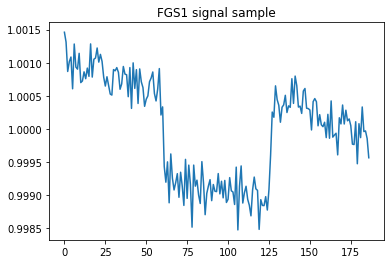

In [9]:
lc = data_train_FGS[15].sum(axis=(1,2))
plt.plot(lc/lc.mean())
plt.title(f'FGS1 signal sample')
plt.show()



We divide the images by the star flux assuming the first and last 50 instants belong to the out of transit.



In [10]:

# def create_dataset_norm(dataset1, dataset2) :
#     dataset_norm1 = np.zeros(dataset1.shape)
#     dataset_norm2 = np.zeros(dataset1.shape)
#     dataset_min = dataset1.min()
#     dataset_max = dataset1.max()
#     dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
#     dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - dataset_min)
#     return dataset_norm1, dataset_norm2


# def norm_star_spectrum (signal) :
#     img_star = signal[:,:50].mean(axis = 1) + signal[:,-50:].mean(axis = 1)
#     return signal/img_star[:,np.newaxis,:]

# dataset_norm = norm_star_spectrum(dataset)
# print(dataset_norm.shape)

dataset_norm = dataset
print(dataset_norm.shape)
# dataset_norm = np.transpose(dataset_norm,(0,2,1))
# print(dataset_norm.shape)




(673, 187, 282)


we split the targets and observations between valid and train, and normalize the data.

In [11]:

cut_inf, cut_sup = 39, 321 # we have previously cut the data along the wavelengths to remove the edges, 
#this is to match with the targets range in the make data file
l = cut_sup - cut_inf
wls = np.arange(l)


def split (data, N) :
    list_planets = random.sample(range(0, data.shape[0]), N_train)
    list_index_1 = np.zeros(data.shape[0], dtype = bool)
    for planet in list_planets :
        list_index_1[planet] = True
    data_1 = data[list_index_1]
    data_2 = data[~list_index_1]
    return data_1, data_2, list_index_1

N_train = 8*N//10

# Validation and train data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train)
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]


print(train_obs.shape, valid_obs.shape, train_targets.shape, valid_targets.shape)



(538, 187, 282) (135, 187, 282) (538, 282) (135, 282)


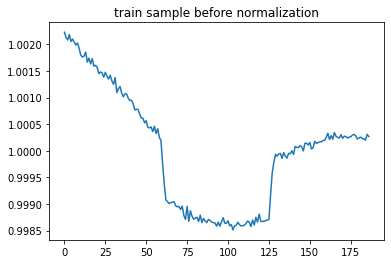

In [12]:
lc = train_obs[0].sum(axis=(1))
plt.plot(lc/lc.mean())
plt.title(f'train sample before normalization')
plt.show()



We normalize the targets so that they range between 0 and 1, centered on zero

In [13]:
##### normalization of the targets ###

def targets_normalization(data):
    data_max = np.absolute(data).max()
    # print(data_max)
    data = data/data_max
    return data, data_max

def targets_norm_back (data, data_abs_max) : 
    return data * data_abs_max

train_targets_norm, train_targets_abs_max = targets_normalization(train_targets)
valid_targets_norm, valid_targets_abs_max = targets_normalization(valid_targets)
print(train_targets_norm.shape, valid_targets_norm.shape)
print(train_targets.min(), train_targets.max(), valid_targets.min(), valid_targets.max())
print(train_targets_norm.min(), train_targets_norm.max(), valid_targets_norm.min(), valid_targets_norm.max())



(538, 282) (135, 282)
0.0003962682120083 0.0079919505169717 0.0004042189394015 0.0078913451026779
0.04958341660984827 1.0 0.05122307213054587 1.0


In [14]:
train_targets_norm.min(), train_targets_norm.max(), valid_targets_norm.min(), valid_targets_norm.max()

(0.04958341660984827, 1.0, 0.05122307213054587, 1.0)

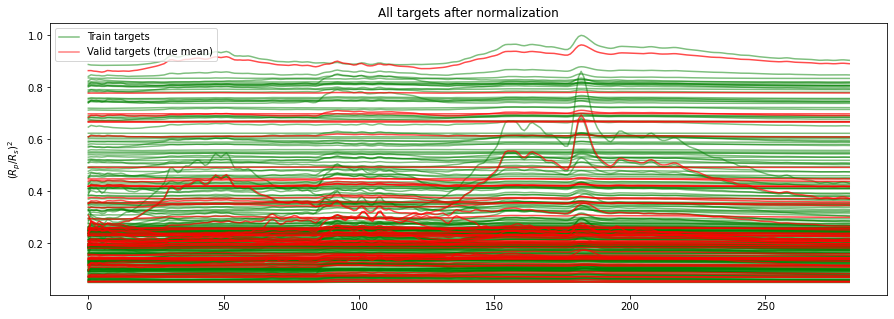

In [15]:
plt.figure(figsize=(15,5))

for i in range (240) :
    plt.plot(wls, train_targets_norm[i], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (60) :
    plt.plot(wls, valid_targets_norm[i], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('All targets after normalization')
plt.show()



observations:

In [16]:
print(train_obs.shape, valid_obs.shape)



(538, 187, 282) (135, 187, 282)


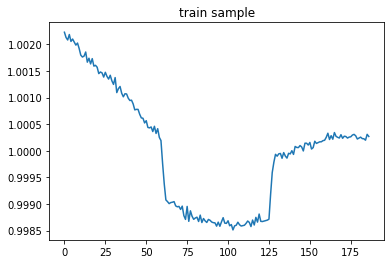

In [17]:
lc = train_obs[0].sum(axis=(1))
plt.plot(lc/lc.mean())
plt.title(f'train sample')
plt.show()



We cut the transit to keep the in-transit. We assume an arbitrary transit duration of 40 instants with a transit occuring between 75 and 115.



In [18]:
##### Subtracting the out transit signal #####
def suppress_out_transit (data, ingress, egress) : 
    data_in = data[:, ingress:egress,:]
    return data_in

ingress, egress = 75,115
train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)

print(train_obs_in.shape, valid_obs_in.shape)


(538, 40, 282) (135, 40, 282)


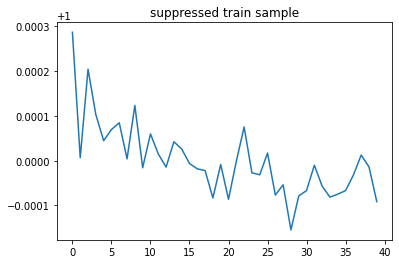

In [19]:
lc = train_obs_in[0].sum(axis=(1))
plt.plot(lc/lc.mean())
plt.title(f'suppressed train sample')
plt.show()





We use the same normalization as for the targets, i.e. between 0 and 1


In [20]:

def normalize_obs(data):
    data_max = np.absolute(data).max()
    # print(data_max)
    data = data/data_max
    return data
    
train_obs_norm = normalize_obs(train_obs_in)
valid_obs_norm = normalize_obs(valid_obs_in)
print(train_obs_norm.shape, valid_obs_norm.shape)
print(train_obs.min(), train_obs.max(), valid_obs.min(), valid_obs.max())
print(train_obs_norm.min(), train_obs_norm.max(), valid_obs_norm.min(), valid_obs_norm.max())


# data_train_AIRS_norms = normalize_obs(data_train_AIRS.sum(3))
# data_train_FGS_norms = normalize_obs(data_train_FGS.sum(3))
# print(data_train_AIRS_norms.shape, data_train_FGS_norms.shape)
# print(data_train_AIRS_norms.min(), data_train_AIRS_norms.max(), data_train_FGS_norms.min(), data_train_FGS_norms.max())



(538, 40, 282) (135, 40, 282)
89474.96720012509 4862021.774283424 89690.98930228219 4840576.174372189
0.01852878666683108 1.0 0.018542219890266554 1.0


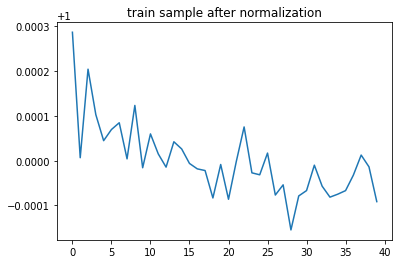

In [28]:
lc = train_obs_norm[0].sum(axis=(1))
plt.plot(lc/lc.mean())
plt.title(f'train sample after normalization')
plt.show()



In [29]:
wls.shape[0]


282

## Train 2D CNN

dataset class

In [30]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        super().__init__()
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.targets)
        
    def __getitem__(self, index):
        return (self.data[index], self.targets[index])
    

    

Data and directories


In [31]:
# dataset
# data_dir

ckpt_dir = output_dir + "/checkpoints"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    print(f"Directory {ckpt_dir} created.")
else:
    print(f"Directory {ckpt_dir} already exists.")

    
    

Directory /home/ulaval.ca/maelr5/scratch/finalunet_outputs already exists.
Directory /home/ulaval.ca/maelr5/scratch/finalunet_outputs/checkpoints already exists.


## trainer callbacks

In [58]:
subtask = 'version1'

# Trainer callbacks
callbacks = []
callbacks.append(
    ModelCheckpoint(
        monitor='val_loss',
        save_top_k=1,
        save_last=True,
        dirpath=ckpt_dir+f'/{subtask}/',
        filename=f'{subtask}_{task}'+'-{epoch}-{val_loss:.2f}',
        verbose=False,
        mode='min',
        # dirpath=str(ckpt_dir),
    )
)

# callbacks.append(
#     EarlyStopping(
#         monitor='val_loss',
#         patience=20,
#         mode='min',
#     )
# )
    
callbacks.append(LearningRateMonitor(logging_interval="epoch"))

    

## create 2DUNeT model and pl module

In [59]:

# optimizer
lr = 0.001

# dataloader
batch_size = 1

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    )
    return conv


class UNet2D(nn.Module):
    def __init__(
        self, input_channels=1, output_channels=1, features=[64, 128, 256, 512]
    ):
        super(UNet2D, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down part of UNet
        for feature in features:
            self.downs.append(double_conv(input_channels, feature))
            input_channels = feature

        # up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2,
                    feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.ups.append(double_conv(feature * 2, feature))

        self.bottleneck = double_conv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], output_channels, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,features[0]))
        self.linear = nn.Linear(features[0],wls.shape[0])

    def forward(self, x):
        x = x.unsqueeze(1).float()
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        x = self.final_conv(x)
        x = self.avgpool(x)
        x = Flatten()(x)
        return self.linear(x)


class Base2DModule(pl.LightningModule):
    def __init__(self, train_data, train_labels, valid_data, valid_labels):
        super().__init__()

        self.model = UNet2D()
        self.save_hyperparameters()
        self.loss = nn.MSELoss()
        # print(train_data.dtype, valid_data.dtype)
        self.tr = MyDataset(train_data, train_labels)
        # print(self.train)
        self.v = MyDataset(valid_data, valid_labels)
        # self.test = 
        self.validation_step_outputs = []

    def train_dataloader(self):
        train_loader = DataLoader(self.tr, batch_size=batch_size, shuffle=True, num_workers=4)
        # print(train_loader)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.v, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader

    # def test_dataloader(self):
    #     test_dataloader = DataLoader(self.test, batch_size=batch_size)
    #     return test_dataloader
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200 , gamma=0.2)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        x, y = batch

        batch_size = x.size(0)
        y = y.float()
        # x = x.view(batch_size, -1).float()
        # print(x.shape, y.shape)

        logits = self(x)
        loss = self.loss(logits, y).float()
        self.log('train_loss', loss, on_step=True, on_epoch=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()

        batch_size = x.size(0)
        # x = x.view(batch_size, -1)

        logits = self(x)
        loss = self.loss(logits, y)
        self.validation_step_outputs.append(loss)
        self.log('val_loss', loss)

        return loss
    
    def on_validation_epoch_end(self):
        avg_val_loss = torch.tensor([x for x in self.validation_step_outputs]).mean()

        self.log('avg_val_loss', avg_val_loss, prog_bar=True)
        self.validation_step_outputs.clear()  # Free memory
    
    

## fit the data

In [60]:
train_obs_norm.shape, task

((538, 40, 282), 'finalunet')

In [61]:

csv_logger = CSVLogger(output_dir + "/csv_logs/", name=subtask)
max_epochs = 300

# make Pytorch Lightning trainer
trainer = pl.Trainer(
    logger=csv_logger,
    max_epochs=max_epochs,
    callbacks=callbacks,
    accelerator = 'gpu',
    devices = 1,
    log_every_n_steps=10,
)

# ckpt_resume_path = ''
module2 = Base2DModule(train_obs_norm[:1], train_targets_norm[:1], valid_obs_norm[:2], valid_targets_norm[:2])

print('Running ...')
# fitting procedure
trainer.fit(
    model=module2,
    # ckpt_path=ckpt_resume_path,
)
print('Done.')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running ...



  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet2D  | 31.1 M | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.219   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


Done.


In [62]:

# https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html#lightningmodule-from-checkpoint
model = Base2DModule.load_from_checkpoint("/home/ulaval.ca/maelr5/scratch/finalunet_outputs/checkpoints/version1/last.ckpt").cpu()
# disable randomness, dropout, etc...
model.eval()
# predict with the model
y_hat = model(torch.tensor(train_obs_norm[:1]))
print(y_hat.shape)



torch.Size([1, 282])


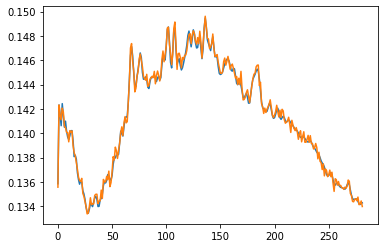

In [63]:
plt.plot(train_targets_norm[0])
plt.plot(y_hat[0].detach().numpy())





## visualize train val loss

   avg_val_loss  epoch  lr-Adam  step  train_loss_epoch  train_loss_step  \
0           NaN    NaN    0.001     0               NaN              NaN   
1           NaN    0.0      NaN     9               NaN         0.029847   
2      0.129235    0.0      NaN     9               NaN              NaN   
3           NaN    0.0      NaN     9          0.175749              NaN   

   val_loss  
0       NaN  
1       NaN  
2  0.129235  
3       NaN  


/tmp/ipykernel_1382769/472931264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename({'train_loss_epoch':'loss'}, axis=1, inplace=True)
/tmp/ipykernel_1382769/472931264.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mode'] = 'train_loss_epoch'
/tmp/ipykernel_1382769/472931264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename({'avg_val_loss':'los

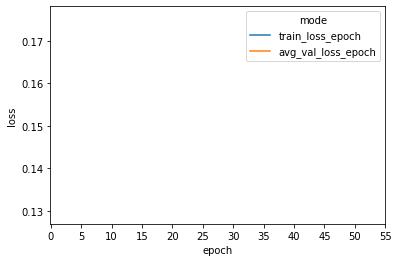

In [27]:
cnn1d_csv = pd.read_csv("/home/ulaval.ca/maelr5/scratch/finalunet_outputs/csv_logs/version0/version_2/metrics.csv")
# print(len(cnn1d_csv))
print(cnn1d_csv.head())


max_epochs=60
df1 = cnn1d_csv[['epoch','train_loss_epoch']]
df1.rename({'train_loss_epoch':'loss'}, axis=1, inplace=True)
df1['mode'] = 'train_loss_epoch'

df2 = cnn1d_csv[['epoch','avg_val_loss']]
df2.rename({'avg_val_loss':'loss'}, axis=1, inplace=True)
df2['mode'] = 'avg_val_loss_epoch'

results = pd.concat([df1, df2], ignore_index=True, sort=False)

# results

ax1 = sns.lineplot(data=results, x ='epoch' , y='loss', hue='mode')

plt.xticks(np.arange(0, max_epochs, 5))

plt.show()



## 2DUNeT inference

## Postprocessing and visualisation

We obtain uncertainties on the predictions by computing a MCDropout.


In [33]:
nb_dropout = 5

def NN_uncertainity(model, x_test, targets_abs_max=0, T=5):
    predictions = []
    for _ in range(T):
        pred_norm = model(torch.tensor(x_test)).detach().numpy()
        pred = targets_norm_back(pred_norm, targets_abs_max)
        predictions += [pred]
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean, std


if do_the_mcdropout :
    spectre_valid_shift, spectre_valid_shift_std = NN_uncertainity(model, valid_obs_norm, T = nb_dropout)

else :

    pred_valid_norm = model.predict([valid_obs_norm])
    pred_valid = targets_norm_back(pred_valid_norm, targets_abs_max)
    spectre_valid_shift = pred_valid
    spectre_valid_shift_std = spectre_valid_shift*0.1

    

In [34]:
residuals = valid_targets_norm - spectre_valid_shift
print('MSE : ', np.sqrt((residuals**2).mean()), 'ppm')



MSE :  0.3513366129731926 ppm


In [39]:
# np.save(f'{output_dir}/pred_valid_shift.npy', spectre_valid_shift)
# np.save(f'{output_dir}/targ_valid_shift.npy', valid_targets_norm)
# np.save(f'{output_dir}/std_valid_shift.npy', spectre_valid_shift_std)



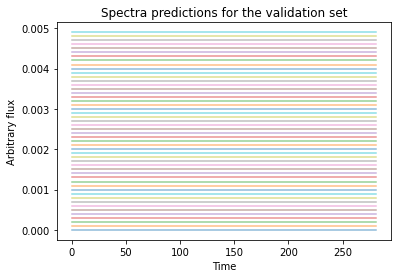

In [35]:
plt.figure()
for i in range (50) :
    plt.plot(spectre_valid_shift[-i]+0.0001*i, '-', alpha = 0.5)
plt.title('Spectra predictions for the validation set')
plt.xlabel('Time')
plt.ylabel('Arbitrary flux')
plt.show()



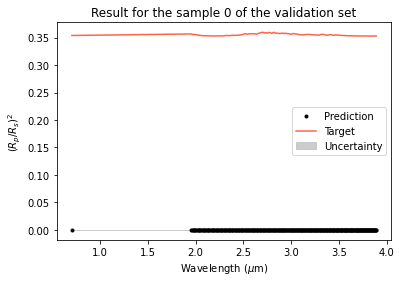

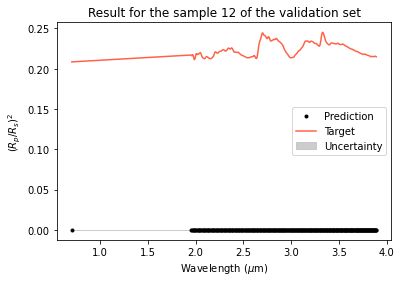

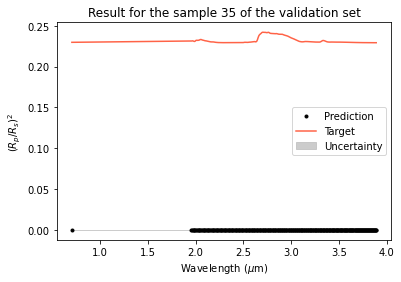

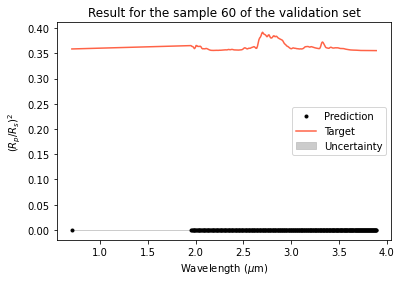

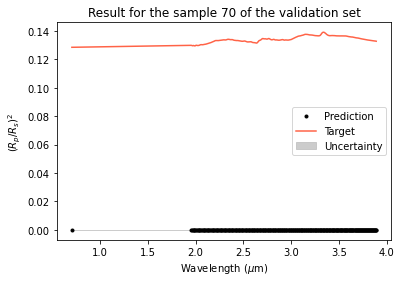

In [37]:
list_valid_planets = [0, 12, 35, 60, 70]
wavelength = np.loadtxt('/home/ulaval.ca/maelr5/scratch/ariel-data-challenge/wavelengths.csv', skiprows=1, delimiter = ',')
uncertainty = spectre_valid_shift_std
for i in (list_valid_planets):
    plt.figure()
    plt.title('Result for the sample {} of the validation set'.format(i))
    plt.plot(wavelength[:-1], spectre_valid_shift[i], '.k', label = 'Prediction')
    plt.plot(wavelength[:-1], valid_targets_norm[i], color = 'tomato', label = 'Target')
    plt.fill_between(wavelength[:-1], spectre_valid_shift[i] - spectre_valid_shift_std[i], spectre_valid_shift[i] + spectre_valid_shift_std[i], color='silver', alpha = 0.8, label = 'Uncertainty')
    plt.legend()
    plt.ylabel(f'$(R_p/R_s)^2$')
    plt.xlabel(f'Wavelength ($\mu$m)')
    plt.show()




In [38]:
######## ADD THE FLUCTUATIONS TO THE MEAN ########
def add_the_mean (shift, mean) :
    return shift + mean[:,np.newaxis]

predictions_valid = spectre_valid_shift #add_the_mean(spectre_valid_shift,spectre_valid_wc)

predictions_std_valid = spectre_valid_shift_std #np.sqrt(spectre_valid_std_wc[:,np.newaxis]**2 + spectre_valid_shift_std**2)



In [39]:
predictions_valid.shape, predictions_std_valid.shape



((135, 282), (135, 282))

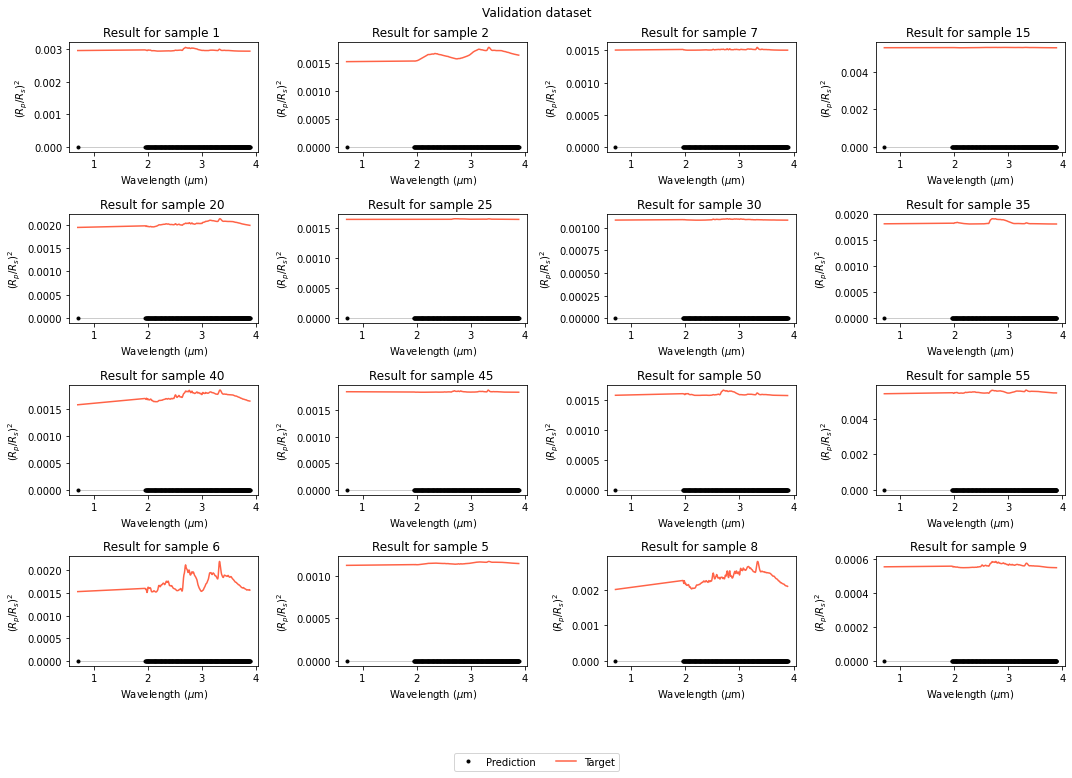

In [41]:
uncertainty = predictions_std_valid

def plot_one_sample_valid(ax, p):
    ax.set_title(f'Result for sample {p} ')
    line1, = ax.plot(wavelength[:-1], predictions_valid[p], '.k', label='Prediction')
    line2, = ax.plot(wavelength[:-1], valid_targets[p], color='tomato', label='Target')
    ax.fill_between(wavelength[:-1], predictions_valid[p, :] - uncertainty[p], predictions_valid[p, :] + uncertainty[p], color='silver', alpha=0.8, label='Uncertainty')
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(lines[:2], ['Prediction', 'Target'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Validation dataset')
plt.tight_layout()
plt.show()




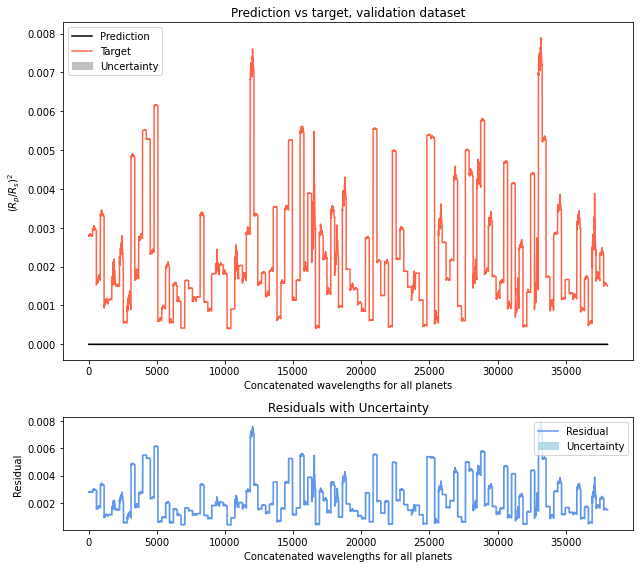

MSE :  2772.5184601774436 ppm


In [42]:
######## PLOTS THE RESULT ########
predictions = predictions_valid
targets_plot = valid_targets
std = predictions_std_valid

predictions_concatenated_plot = np.concatenate(predictions, axis=0)
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0)
spectre_valid_std_concatenated = np.concatenate(std, axis=0)
residuals = targets_concatenated_plot - predictions_concatenated_plot
uncertainty = spectre_valid_std_concatenated

fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]})


axs[0].plot(wls_concatenated, predictions_concatenated_plot, '-', color='k', label="Prediction")
axs[0].plot(wls_concatenated, targets_concatenated_plot, '-', color='tomato', label="Target")
axs[0].fill_between(np.arange(len(wls_concatenated)),
                    predictions_concatenated_plot - uncertainty,
                    predictions_concatenated_plot + uncertainty,
                    color='silver', alpha=1, label='Uncertainty')
axs[0].set_xlabel('Concatenated wavelengths for all planets')
axs[0].set_ylabel(f'$(R_p/R_s)^2$')
axs[0].set_title('Prediction vs target, validation dataset')
axs[0].legend()

axs[1].plot(wls_concatenated, residuals, '-', color='cornflowerblue', label="Residual")
axs[1].fill_between(np.arange(len(wls_concatenated)),
                    residuals - uncertainty,
                    residuals + uncertainty,
                    color='lightblue', alpha=0.9, label='Uncertainty')
axs[1].set_xlabel('Concatenated wavelengths for all planets')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals with Uncertainty')
axs[1].legend()

plt.tight_layout()
plt.show()

print('MSE : ',np.sqrt((residuals**2).mean())*1e6, 'ppm')



In [50]:
np.save(f'{output_dir}/pred_valid.npy', predictions_valid)
np.save(f'{output_dir}/std_valid.npy', predictions_std_valid)

